# PRMT-1985 [HYPOTHESIS] A high proportion of pending transfers are caused by a small group of practices

### Hypothesis
We believe that a large proportion of pending transfers are caused by a small group of practices receiving, regardless of the sending supplier. 

We will know this to be true when we can see that the same practices causing a high number of EMIS-EMIS pending transfers are the same as those causing TPP-EMIS or Vision-EMIS, (and the same would occur for each supplier as a receiver)

# Import and setup Data

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd 
import numpy as np
# Using data generated from branch PRMT-1742-duplicates-analysis.
# This is needed to correctly handle duplicates.
# Once the upstream pipeline has a fix for duplicate EHRs, then we can go back to using the main output.
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet"
]

transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

# In the data from the PRMT-1742-duplicates-analysis branch, these columns have been added , but contain only empty values.
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)


# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data

has_at_least_one_successful_integration_code = lambda errors: any((np.isnan(e) or e==15 for e in errors))
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(has_at_least_one_successful_integration_code)
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

# Correctly interpret certail sender errors as failed.
# This is explained in PRMT-1974. Eventaully this will be fixed upstream in the pipeline. 
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

# If the record integrated after 28 days, change the status back to pending.
# This is to handle each month consistentently and to always reflect a transfers status 28 days after it was made.
# TBD how this is handled upstream in the pipeline
twenty_eight_days_in_seconds=28*24*60*60
transfers_after_month_bool=transfers['sla_duration']>twenty_eight_days_in_seconds
transfers_pending_at_month_bool=transfers_after_month_bool & transfers_integrated_late_bool
transfers.loc[transfers_pending_at_month_bool,'status']='PENDING'
transfers_with_early_error_bool=(~transfers.loc[:,'sender_error_code'].isna()) |(~transfers.loc[:,'intermediate_error_codes'].apply(len)>0)
transfers.loc[transfers_with_early_error_bool & transfers_pending_at_month_bool,'status']='PENDING_WITH_ERROR'

# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [3]:
# For each requesting practice, what is the proportion in each status?
status_counts=transfers.pivot_table(index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0)
status_counts_percentage=status_counts.div(status_counts.sum(axis=1),axis=0).multiply(100).round(2)
status_counts_percentage=status_counts_percentage[['INTEGRATED','INTEGRATED LATE','PENDING','PENDING_WITH_ERROR','FAILED']]
status_counts_percentage.columns=status_counts_percentage.columns.str.title().str.replace("_"," ") + ' %'
status_counts_percentage.head()

status,Integrated %,Integrated Late %,Pending %,Pending With Error %,Failed %
requesting_practice_asid,,,,,
000032357014,71.27,16.00,9.82,0.36,2.55
000166272047,92.31,1.28,6.41,0.00,0.00
000594443012,89.54,0.00,1.67,0.00,8.79
000685393043,99.07,0.00,0.93,0.00,0.00
001471461010,94.74,1.00,1.50,0.00,2.76


In [4]:
transfers_reduced_columns = transfers[["requesting_practice_asid","requesting_supplier","sending_supplier", "status"]].copy()
is_pending_transfers = transfers["status"] == "PENDING"
transfers_reduced_columns["is_pending"] = is_pending_transfers
transfers_reduced_columns = transfers_reduced_columns.drop("status", axis=1)
transfers_reduced_columns.head()

,requesting_practice_asid,requesting_supplier,sending_supplier,is_pending
0,323917613040,EMIS,EMIS,False
1,792911523019,EMIS,EMIS,False
2,981416634047,EMIS,EMIS,False
3,310097028016,EMIS,EMIS,False
4,200000001906,TPP,EMIS,False


# For all Pending, what is the distribution by number of Practices

In [5]:
def transfers_quantile_status_table(transfers_df,status,quantiles=5):
    practice_status_table=pd.pivot_table(transfers_df,index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0)
    
    practice_status_table['TOTAL']=practice_status_table.sum(axis=1)
    
    practice_profile_data=practice_status_table.sort_values(by=status,ascending=False)

    cumulative_percentage=practice_profile_data[status].cumsum()/practice_profile_data[status].sum()

    practice_profile_data['Percentile Group']=(100/quantiles)*np.ceil(cumulative_percentage*quantiles)

    practice_profile_data=practice_profile_data.groupby('Percentile Group').agg({status:'sum','TOTAL':'sum','INTEGRATED':'count'}).astype(int)
    practice_profile_data=practice_profile_data.rename({status:'Total ' + status,'TOTAL':'Total Transfers','INTEGRATED':'Total Practices'},axis=1)

    practice_profile_data_percentages=(100*practice_profile_data/practice_profile_data.sum()).round(2)
    practice_profile_data_percentages.columns= "% " + practice_profile_data_percentages.columns

    return pd.concat([practice_profile_data,practice_profile_data_percentages],axis=1)

In [6]:
transfers_quantile_status_table(transfers,"PENDING")

,Total PENDING,Total Transfers,Total Practices,% Total PENDING,% Total Transfers,% Total Practices
Percentile Group,,,,,,
20.0,9332,28958,39,19.91,2.16,0.58
40.0,9380,46415,127,20.02,3.46,1.89
60.0,9403,115320,326,20.07,8.59,4.86
80.0,9373,326576,948,20.00,24.31,14.14
100.0,9372,825965,5264,20.00,61.49,78.52


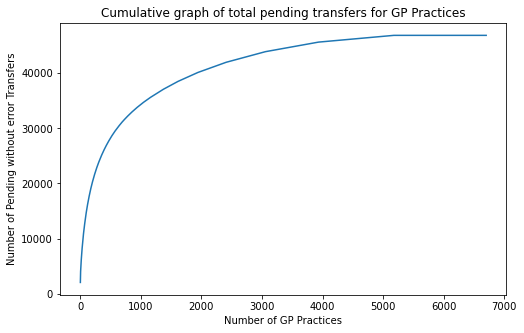

In [7]:

practice_status_table=pd.pivot_table(transfers,index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0).sort_values(by="PENDING",ascending=False)
ax=practice_status_table['PENDING'].cumsum().reset_index(drop=True).plot(figsize=(8,5))
ax.set_ylabel('Number of Pending without error Transfers')
ax.set_xlabel('Number of GP Practices')
ax.set_title('Cumulative graph of total pending transfers for GP Practices')
plt.gcf().savefig('Cumulative_pending_transfers.jpg')

# For practices of each Supplier, does their "policy" towards pending transfers differ by the supplier they are requesting from?

In [8]:
suppliers_to_investigate = ["EMIS", "TPP", "Vision"]

In [9]:
pending_by_supplier_pathway=transfers_reduced_columns.pivot_table(index='requesting_supplier',columns='sending_supplier',values='is_pending',aggfunc='mean').multiply(100).round(2)
pending_by_supplier_pathway=pending_by_supplier_pathway.loc[suppliers_to_investigate,suppliers_to_investigate]
pending_by_supplier_pathway

sending_supplier,EMIS,TPP,Vision
requesting_supplier,,,
EMIS,2.08,2.85,42.58
TPP,3.31,80.75,38.91
Vision,4.23,1.39,55.97


### Correlations of volume pending

In [10]:
pending_transfers_supplier_pathways_pivot = pd.pivot_table(transfers_reduced_columns, index=["requesting_supplier", "requesting_practice_asid"], columns="sending_supplier", values="is_pending", aggfunc="sum").fillna(0)

pending_transfers_as_list = [pending_transfers_supplier_pathways_pivot.loc[supplier].corr().stack().rename(supplier) for supplier in suppliers_to_investigate]
pending_transfers_volume_between_suppliers_correlation = pd.concat(pending_transfers_as_list, axis=1)
pending_transfers_volume_between_suppliers_correlation.loc[[("EMIS", "TPP"), ("EMIS", "Vision"), ("TPP", "Vision")]].round(2)

EMIS   TPP  Vision
sending_supplier sending_supplier                    
EMIS             TPP               0.81 -0.00    0.81
                 Vision            0.09  0.24    0.21
TPP              Vision            0.05  0.02    0.09

### Correlations of % pending

In [11]:
pending_transfers_supplier_pathways_pivot = pd.pivot_table(transfers_reduced_columns, index=["requesting_supplier", "requesting_practice_asid"], columns="sending_supplier", values="is_pending", aggfunc="mean").fillna(0)

pending_transfers_as_list = [pending_transfers_supplier_pathways_pivot.loc[supplier].corr().stack().rename(supplier) for supplier in suppliers_to_investigate]
pending_transfers_percentage_between_suppliers_correlation = pd.concat(pending_transfers_as_list, axis=1)
pending_transfers_percentage_between_suppliers_correlation.loc[[("EMIS", "TPP"), ("EMIS", "Vision"), ("TPP", "Vision")]].round(2)

EMIS   TPP  Vision
sending_supplier sending_supplier                    
EMIS             TPP               0.85 -0.01    0.48
                 Vision            0.08  0.06    0.31
TPP              Vision            0.08  0.03    0.17

# Create frame of all practices ranked by pending
Output to Excel

In [16]:
# Total volume Pending by practice
pending_transfers_supplier_pathways_pivot = pd.pivot_table(transfers_reduced_columns, index=["requesting_supplier", "requesting_practice_asid"], columns="sending_supplier", values="is_pending", aggfunc="sum").fillna(0)
pending_transfers_for_supplier_pathways = pending_transfers_supplier_pathways_pivot.copy().astype(int)
pending_transfers_for_supplier_pathways = pending_transfers_for_supplier_pathways.loc[:, ["EMIS","TPP","Vision","Microtest","Unknown"]]
pending_transfers_for_supplier_pathways.insert(0, "Total Pending Transfers", pending_transfers_for_supplier_pathways.sum(axis=1))

# Percentage Pending by practice
pending_transfers_supplier_pathways_pivot_percentage = pd.pivot_table(transfers_reduced_columns, index=["requesting_supplier", "requesting_practice_asid"], columns="sending_supplier", values="is_pending", aggfunc="mean").fillna(0)
pending_transfers_supplier_pathways_percentage = pending_transfers_supplier_pathways_pivot_percentage.copy().round(4).multiply(100)
pending_transfers_supplier_pathways_percentage = pending_transfers_supplier_pathways_percentage.loc[:, ["EMIS","TPP","Vision","Microtest","Unknown"]]
pending_transfers_supplier_pathways_percentage.columns = pending_transfers_supplier_pathways_percentage.columns + " %"
 
# Join the two and clean up and re-organise the frame    
complete_pending_transfers_for_supplier_pathways = pd.concat([pending_transfers_for_supplier_pathways, pending_transfers_supplier_pathways_percentage], axis=1)
complete_pending_transfers_for_supplier_pathways = complete_pending_transfers_for_supplier_pathways.sort_values(by="Total Pending Transfers", ascending=False)
complete_pending_transfers_for_supplier_pathways = asid_lookup[["ASID", "PostCode", "OrgName"]].merge(complete_pending_transfers_for_supplier_pathways.reset_index(), right_on="requesting_practice_asid", left_on="ASID", how="right")
complete_pending_transfers_for_supplier_pathways=complete_pending_transfers_for_supplier_pathways.drop('requesting_practice_asid',axis=1).set_index(['requesting_supplier','ASID'])#.insert(0,"Supplier",supplier)

# Add in the % in each status for each supplier
complete_pending_transfers_for_supplier_pathways=complete_pending_transfers_for_supplier_pathways.reset_index().merge(status_counts_percentage,left_on='ASID',right_index=True,how='left').set_index(['requesting_supplier','ASID'])

# Save to Excel
complete_pending_transfers_for_supplier_pathways.reset_index().to_excel('PRMT-1985 Pending Transfers all practices.xlsx')

complete_pending_transfers_for_supplier_pathways.loc['Vision'].head(20)

,PostCode,OrgName,Total Pending Transfers,EMIS,TPP,Vision,Microtest,Unknown,EMIS %,TPP %,Vision %,Microtest %,Unknown %,Integrated %,Integrated Late %,Pending %,Pending With Error %,Failed %
ASID,,,,,,,,,,,,,,,,,,
896286726030,SE9 6ER,EVEREST HEALTH PARTNERSHIP,206,7,1,198,0,0,2.33,2.86,84.62,0.0,0.00,43.16,0.18,36.14,0.18,20.35
244934959036,M25 1EX,WHITTAKER LANE MED CENTRE,186,77,1,108,0,0,42.31,6.67,93.10,0.0,0.00,3.83,4.79,59.42,0.64,31.31
927374150047,SW19 5BY,WIMBLEDON VILLAGE PRACTICE,126,112,10,4,0,0,51.85,14.08,100.00,0.0,0.00,8.93,0.34,43.30,0.34,47.08
052047562039,BL8 4AD,TOWER FAMILY HEALTHCARE,121,1,1,119,0,0,0.47,2.17,58.91,0.0,0.00,41.83,1.09,26.36,0.00,30.72
066105116033,M28 0BB,SALFORD PRIMARY CARE TOGETHER,118,67,5,46,0,0,22.64,7.58,75.41,0.0,0.00,26.71,2.84,27.90,0.24,42.32
077368646038,ME19 4JF,WEST MALLING GROUP PRACTICE,111,44,2,65,0,0,14.01,6.67,63.73,0.0,0.00,31.84,9.19,24.89,0.22,33.86
613459465035,SE9 5DQ,ELTHAM MEDICAL PRACTICE,103,4,0,99,0,0,1.58,0.00,72.26,0.0,0.00,48.50,0.69,23.79,0.00,27.02
814246595031,TN13 3NT,ST JOHN'S MEDICAL PRACTICE,87,67,6,14,0,0,47.18,35.29,100.00,0.0,0.00,0.00,0.00,50.29,0.00,49.71
960843613030,ME16 8AX,BOWER MOUNT MEDICAL PRACTICE,76,3,0,73,0,0,1.18,0.00,57.94,0.0,0.00,47.54,0.00,18.72,0.00,33.74


In [13]:
# View Emis practices
complete_pending_transfers_for_supplier_pathways.loc["EMIS"].head(10)

,PostCode,OrgName,Total Pending Transfers,EMIS,TPP,Vision,Microtest,Unknown,EMIS %,TPP %,Vision %,Microtest %,Unknown %
ASID,,,,,,,,,,,,,
615075629043,NR4 7TJ,UEA MEDICAL CENTRE,2043,917,1079,36,0,11,82.09,83.97,90.00,0.0,64.71
200000010928,ME17 4PL,GREENSANDS,755,5,0,750,0,0,1.42,0.00,65.73,0.0,0.00
669024222046,LA1 1PN,LANCASTER MEDICAL PRACTICE,618,442,145,31,0,0,21.46,18.71,42.47,0.0,0.00
260198413015,ME14 4DS,BEARSTED,368,211,18,139,0,0,63.94,60.00,91.45,0.0,0.00
994133653042,IG2 6UP,GANTS HILL MEDICAL CENTRE,242,201,33,8,0,0,81.05,80.49,100.00,0.0,0.00
540917834041,RG40 1PH,BURMA HILL PRACTICE,229,199,27,3,0,0,87.67,87.10,100.00,0.0,0.00
926102461049,HA9 6PW,HAZELDENE MEDICAL CENTRE,217,139,49,26,0,3,2.86,2.84,28.57,0.0,27.27
200000000897,HA2 7DU,THE RIDGEWAY SURGERY,204,167,36,1,0,0,80.29,76.60,100.00,0.0,0.00
200000023705,SE10 8EX,BURNEY STREET PMS,192,139,32,21,0,0,46.49,48.48,70.00,0.0,0.00


In [14]:
gants_hill = (transfers["requesting_practice_asid"] == "926102461049") & (transfers["status"] == "PENDING") & (transfers["sending_supplier"] == "Vision")
gants_hill = transfers.loc[gants_hill]

#gants_hill.head(20)